To build a machine learning classification model that automatically detects fraudulent credit card transactions from legitimate transactions using Gradient Boosting (XGBoost / LightGBM) within a clean sklearn pipeline.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

In [6]:
df.columns.tolist()

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.isnull().sum().sort_values(ascending=False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

In [9]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

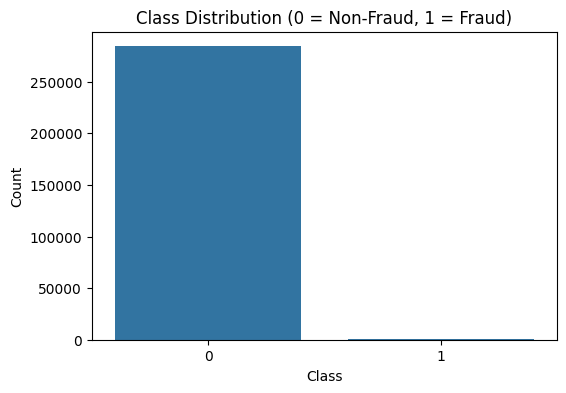

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

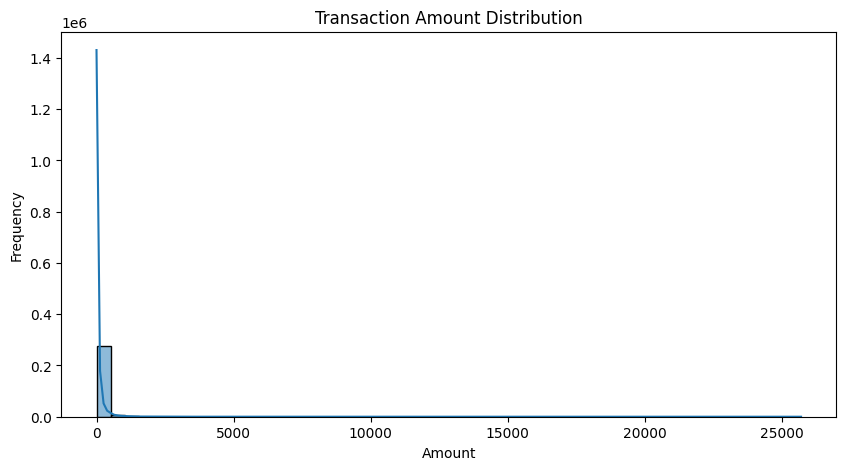

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

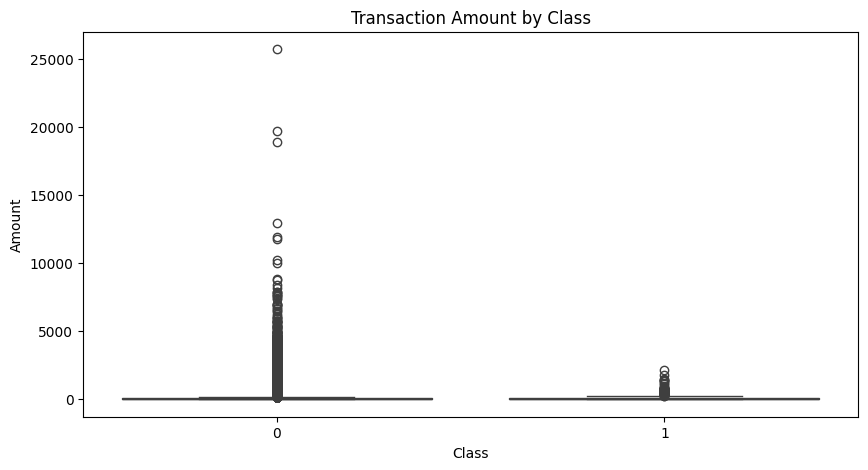

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.show()

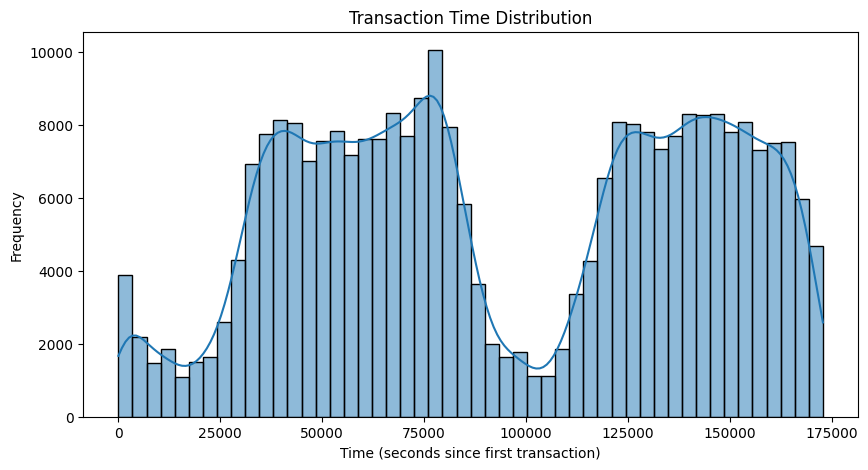

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Transaction Time Distribution')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Frequency')
plt.show()

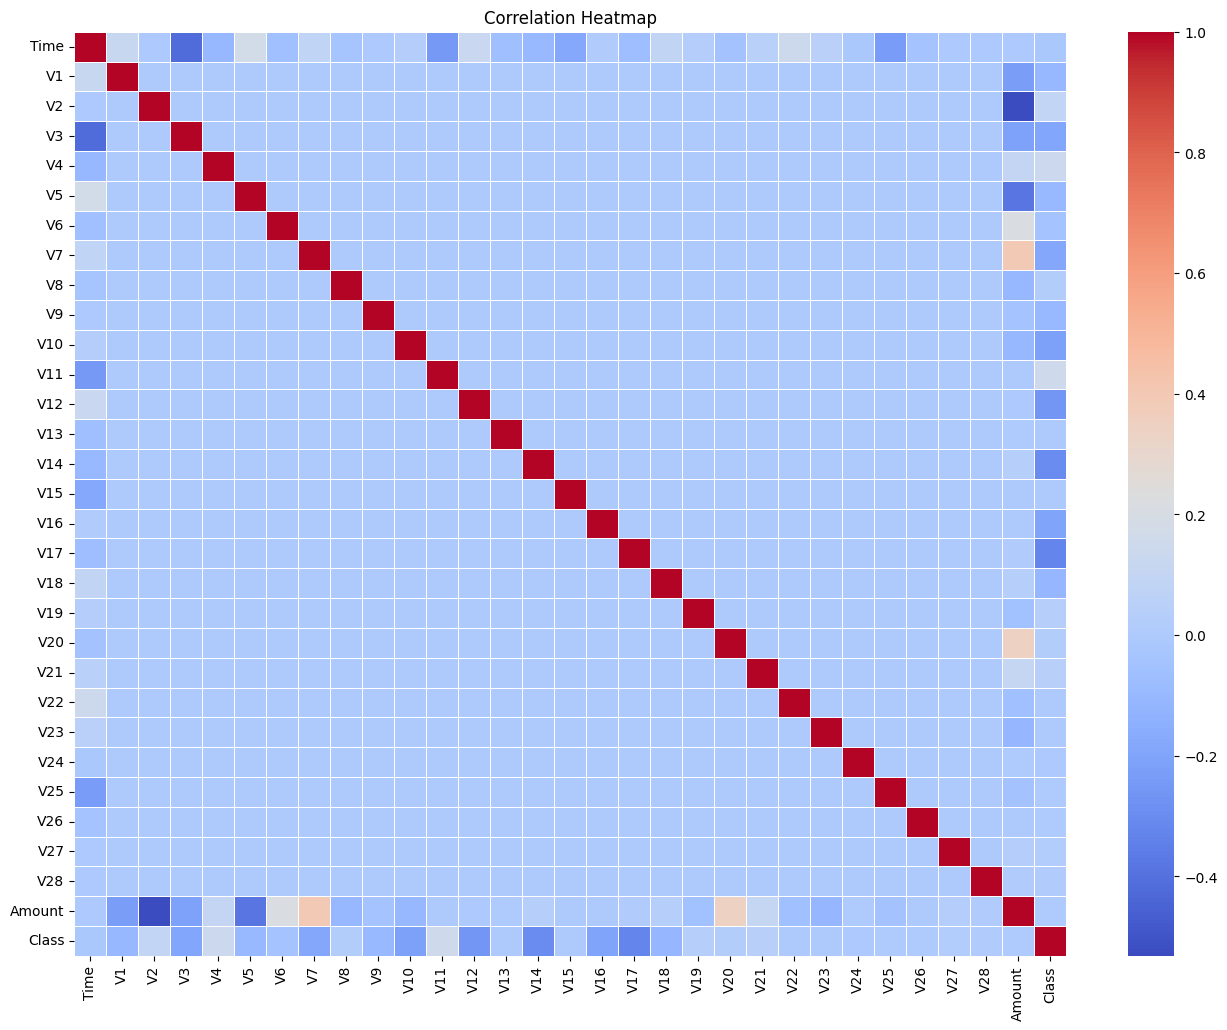

In [15]:
plt.figure(figsize=(16,12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [17]:
X = df.drop('Class', axis=1)
y = df['Class']

In [18]:
# Columns to scale
scale_cols = ['Amount', 'Time']
# Columns to pass through (PCA features)
passthrough_cols = [col for col in X.columns if col not in scale_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), scale_cols),
    ('passthrough', 'passthrough', passthrough_cols)
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [20]:
from xgboost import XGBClassifier

In [24]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])  # Handling imbalance
)

In [25]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', model)
])

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Amount', 'Time']),
                                                 ('passthrough', 'passthrough',
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28'])])),
                ('classifier',
                 XGBClassifier(base_score=None, b...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [27]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)

In [28]:
y_pred = pipeline.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.89      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



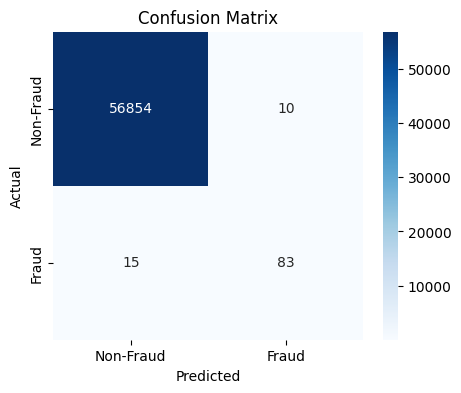

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [36]:
# Hyperparameter grid for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': uniform(0.01, 0.3),
    'classifier__subsample': uniform(0.7, 0.3),
    'classifier__colsample_bytree': uniform(0.7, 0.3),
    'classifier__gamma': uniform(0, 5)
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best Parameters
print("\nBest Hyperparameters:")
print(random_search.best_params_)

# Evaluate on test set
y_pred = random_search.predict(X_test)


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
{'classifier__colsample_bytree': 0.7076257380232285, 'classifier__gamma': 0.5394571349665223, 'classifier__learning_rate': 0.019428755706020276, 'classifier__max_depth': 9, 'classifier__n_estimators': 340, 'classifier__subsample': 0.794306794322898}


In [37]:
import joblib
joblib.dump(random_search.best_estimator_, 'xgb_fraud_pipeline.pkl')

['xgb_fraud_pipeline.pkl']